## 1. Install dependences and load data

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import imghdr
import matplotlib
from PIL import Image

In [2]:
# connect to drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
# Avoid OutOfMemory error | I do not have a GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
# Get all attributes of image_dataset_from_directory
tf.keras.utils.image_dataset_from_directory??

In [29]:
# Define the paths to the train and test directories
train_dir = '/content/drive/MyDrive/ml_project/data/train'
test_dir = '/content/drive/MyDrive/ml_project/data/test'

# with keras.utils we do not have to code the labels, and it preprocesses
## These build the data pipeline
train = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                    )
test = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                   )
# if I add color_mode = 'grayscale' pictures appear blue/yello, idk y

# train and test are NOT preloaded, they are generators.
# we first convert into a numpy iterator

Found 4733 files belonging to 2 classes.
Found 1194 files belonging to 2 classes.


In [30]:
# with iterators we can access the generator from the data pipeline
## These allow to access the data pipeline
train_iterator = train.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

In [31]:
# gets another batch from the iterator
## Accessing the data pipeline itself
train_batch = train_iterator.next()
test_batch = test_iterator.next()


In [32]:
#the batches have len = 2, 1 is image representation, 2 is the label
print(len(train_batch))
train_batch[1] # dogs or muffins?

2


array([0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 1], dtype=int32)

In [33]:
print(train_batch[0].shape)
# images represented as numpy arrays
# batch size is 32, last one (3) are the channels (rgb)
# if I put color_mode = 'grayscale' when using tf.keras.utile.image_from_dataset
# I get just one "channel", so last element of the tuple is 1.

(32, 256, 256, 3)


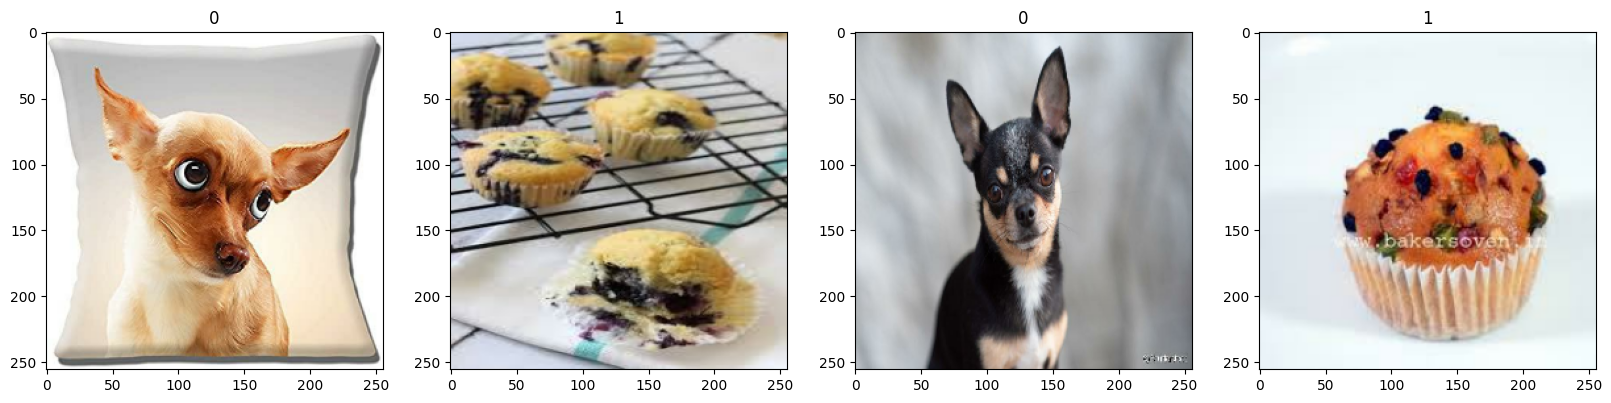

In [34]:
# visualize the images. They have the correct colors!
# 1 is muffins, 0 is chihuahuas
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(train_batch[0][:4]):
  ax[idx].imshow(img.astype(int))
  ax[idx].title.set_text(train_batch[1][idx])

## Data Processing
- Resize all images -> already done
- Bring everything to greyscale -> already done

In [35]:
# shape of each image
print(train_batch[0].shape)
print(train_batch[0].min())
print(train_batch[0].max()) # we want values as small as possible -> /255
# this makes optimization more efficient -> we need to scale values

(32, 256, 256, 3)
0.0
255.0


In [36]:
# we implement the data transformation in the pipeline
# x represent images, y labels
train = train.map(lambda x,y: (x/255,y))
test = test.map(lambda x,y: (x/255,y))


In [37]:
scaled_iterator = train.as_numpy_iterator()
scaled_iterator_test = test.as_numpy_iterator()

In [38]:
train_batch = scaled_iterator.next()
test_batch = scaled_iterator_test.next()

In [39]:
# check the values of the images
print(f"Min value of scaled images: {train_batch[0].min()}")
print(f"Max value of scaled images: {train_batch[0].max()}")

Min value of scaled images: 0.0
Max value of scaled images: 1.0


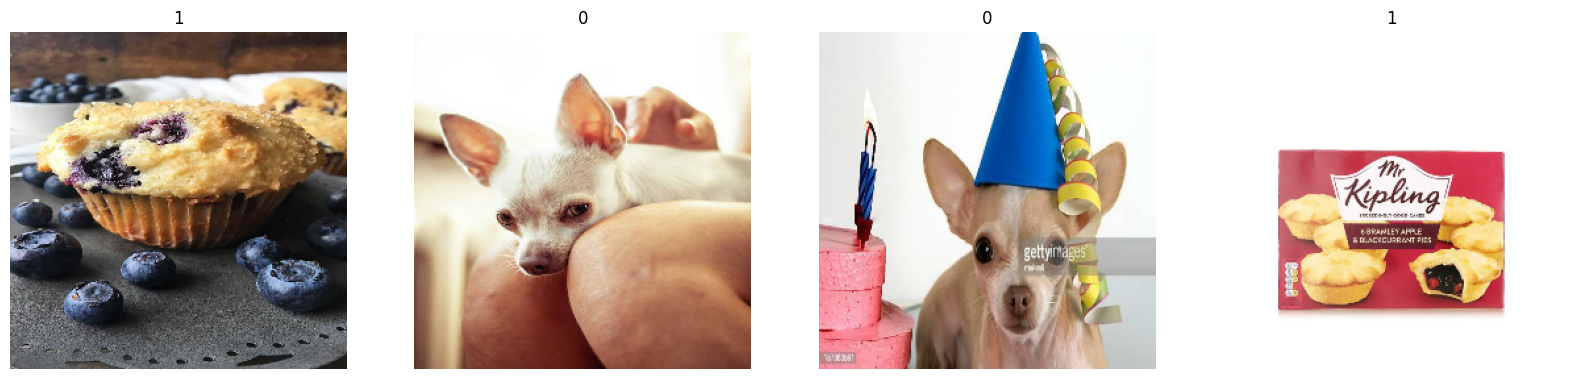

In [40]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(train_batch[0][:4]):
    ax[idx].imshow(img)  # Matplotlib uses default colormap
    ax[idx].axis('off')  # Turn off axis
    ax[idx].title.set_text(train_batch[1][idx])

plt.show()

## Create Validation Data

In [41]:
print(len(train)) # we have 148 batches
train_size = int(len(train)*0.8)
val_size = int(len(train)*0.2) + 1 # + 1 otherwise 1 is missing

print(train_size)
print(val_size)

148
118
30


In [42]:
train_data = train.take(train_size)
val_data = train.skip(train_size).take(val_size)

In [43]:
print(f"len(train) = {len(train_data)}")
print(f"len(val) = {len(val_data)}")
print(f"Length of initial data = {len(train)} = {len(train_data) + len(val_data)}")

len(train) = 118
len(val) = 30
Length of initial data = 148 = 148


## Build the Model

In [44]:
from tensorflow.keras.models import Sequential # good with 1 input 1 output
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [45]:
# initialize the first model
model = Sequential()

In [46]:
# first layer must be input layer or have an imput
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape = (256,256,3))) # change channels from 1 to 3 if use RGB instead of grayscale
# 16 is the number of filers, each filter is 3x3 pixels, 1 is the stride
model.add(MaxPooling2D())
# this takes the maximum value after the relu and returns it
# check MaxPooling2D?? for each 2x2 region (pool) takes the highest value

model.add(Conv2D(32, (3,3), 1, activation='relu')) # now 32 filters
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
# When we apply the conv layer the filters are going to be the last channel.
# We condense the length and width, then the number of filters will form the
# channel value. When we pass values to the dense layer we don't want multiple
# values, but we want to 'flatten' them in a single value (thus the Flatten layer)

# dense layers are fully connected layers
model.add(Dense(256, activation='relu')) # 256 values as output.
model.add(Dense(1 ,activation='sigmoid')) # 1 output only, due to sigmoid




In [47]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])
# we use binary cross entropy since it is a classification problem.

#tf.optimizers. to get all the optimizers

In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

## Train the model

In [49]:
# create a log directory
logdir = 'logs'

In [50]:
# this is going to log how the model trains as it trains
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [51]:
#.fit method -> training component
#.predict -> when we make the predictions
hist = model.fit(train_data,
                 epochs=20,
                 validation_data = val_data,
                 callbacks=[tensorboard_callback])

# This takes hours though..

Epoch 1/20
118/118 [==============================] - 496s 4s/step - loss: 0.6676 - accuracy: 0.7111 - val_loss: 0.5444 - val_accuracy: 0.7189
Epoch 2/20
118/118 [==============================] - 51s 426ms/step - loss: 0.4267 - accuracy: 0.8046 - val_loss: 0.3855 - val_accuracy: 0.8339
Epoch 3/20
118/118 [==============================] - 50s 416ms/step - loss: 0.3532 - accuracy: 0.8464 - val_loss: 0.3747 - val_accuracy: 0.8464
Epoch 4/20
118/118 [==============================] - 53s 439ms/step - loss: 0.3058 - accuracy: 0.8700 - val_loss: 0.3316 - val_accuracy: 0.8548
Epoch 5/20
118/118 [==============================] - 67s 560ms/step - loss: 0.2646 - accuracy: 0.8922 - val_loss: 0.3118 - val_accuracy: 0.8757
Epoch 6/20
118/118 [==============================] - 55s 455ms/step - loss: 0.2212 - accuracy: 0.9105 - val_loss: 0.3066 - val_accuracy: 0.8757
Epoch 7/20
118/118 [==============================] - 53s 438ms/step - loss: 0.1549 - accuracy: 0.9420 - val_loss: 0.2899 - val_accu

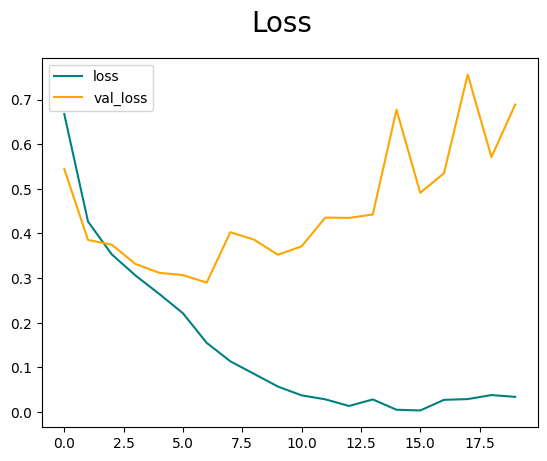

In [55]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'],color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

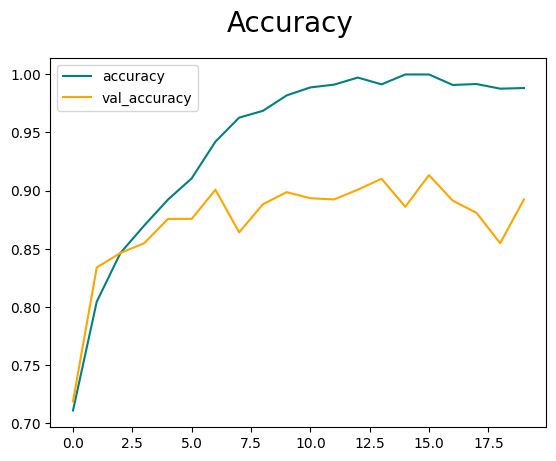

In [56]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange',label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

## Evaluate Performance

The loss decreases steadily over time. However, while initially the validation loss decreases, around the 6th epoch it starts to increaase. This pattern possibly conveys overfitting of our algorithm. To improve this result we may need to apply regularization.

In [57]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [60]:
# To use the metrics we need to establish instances of them
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [58]:
#scaled_iterator_test
len(test)

38

In [61]:
for batch in scaled_iterator_test:
  X, y = batch
  yhat = model.predict(X)
  pre.update_state(y, yhat)
  re.update_state(y, yhat)
  acc.update_state(y, yhat)

1/1 [==============================] - 0s 416ms/step


In [67]:
print(f"Precision: {pre.result():.2f}, Recall: {re.result():.2f}, Accuracy: {acc.result():.2f}")

Precision: 0.90, Recall: 0.75, Accuracy: 0.85


## Save the model


In [69]:
from tensorflow.keras.models import load_model

In [70]:
model.save(os.path.join('models','model1.h5'))
# h5 is a serialization format, like .zip

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# "import" the model
new_model = load_model(os.path.join('models','model1.h5'))